In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [2]:
df = pd.read_csv('./material/aCCF_0623_p_spec.csv')
df = df[df['Unnamed: 0'] % 2 == 0]
df['LATITUDE'] = df['LATITUDE'] * 111000
df['LONGITUDE'] = df['LONGITUDE'] * 85000
df = df.reset_index()
df = df.drop(columns=['index', 'Unnamed: 0'])
df

,LATITUDE,LONGITUDE,FL_hPa,TIME,MERGED,FL
0,3774000.0,-2550000.0,100,2018-06-23 06:00:00,0.113404,100
1,3774000.0,-2550000.0,100,2018-06-23 12:00:00,0.113514,100
2,3774000.0,-2550000.0,100,2018-06-23 18:00:00,0.113482,100
3,3774000.0,-2380000.0,100,2018-06-23 06:00:00,0.113423,100
4,3774000.0,-2380000.0,100,2018-06-23 12:00:00,0.113414,100
...,...,...,...,...,...,...
18223,6660000.0,2380000.0,600,2018-06-23 12:00:00,0.117499,360
18224,6660000.0,2380000.0,600,2018-06-23 18:00:00,0.117676,360
18225,6660000.0,2550000.0,600,2018-06-23 06:00:00,0.116333,360
18226,6660000.0,2550000.0,600,2018-06-23 12:00:00,0.118673,360


In [3]:
df_fuel = pd.read_csv('./material/bada_data.csv', delimiter='\t')
df_fuel = df_fuel[df_fuel['FL'] >= 100]
df_fuel['TAS-MS'] = df_fuel['TAS [kts]'] / 1.94384 # m/s
df_fuel = df_fuel.drop(columns=['TAS [kts]', 'TAS [kts].1', 'TAS [kts].2'])
df_fuel = df_fuel.set_index('FL')
final_dict = {}
for i, row in df_fuel.iterrows():
    d = final_dict.get(i, {})
    d['fuel1'] = row['fuel1']
    d['ROC [ft/min]'] = row['ROC [ft/min]']
    d['fuel2'] = row['fuel2']
    d['ROD [ft/min]'] = row['ROD [ft/min]']
    d['fuel3'] = row['fuel3']
    d['TAS-MS'] = row['TAS-MS']
    final_dict[i] = d
    
final_dict
df_fuel = final_dict

In [4]:
time_grid = 120 # in seconds
total_time = []
uniques = {
    'LONGITUDE': df['LONGITUDE'].unique(),
    'LATITUDE': df['LATITUDE'].unique(),
    'FL': df['FL'].unique(),
    'TIME': [datetime.fromisoformat(x) for x in df['TIME'].unique()]
}
df_optimal = {(row['LONGITUDE'], row['LATITUDE'], row['FL'], datetime.fromisoformat(row['TIME'])): row['MERGED'] for [_, row] in df.iterrows()}

def get_distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

def get_closest(target, column):
    res = min(uniques[column], key = lambda x: abs(x - target))
    return res

def lookup_climate(x,y,z, t):
    #test = df[
    #    (df['LATITUDE'] == get_closest(x, 'LATITUDE')) & 
    #    (df['LONGITUDE'] == get_closest(y, 'LONGITUDE')) & 
    #    (df['FL'] == get_closest(z, 'FL')) & (df['TIME'] == get_closest(t, 'TIME'))
    #]['MERGED'].values[0]
    test = df_optimal[(get_closest(x, 'LONGITUDE'), get_closest(y, 'LATITUDE'), get_closest(z, 'FL'), get_closest(t, 'TIME'))]
    return test
    
def turn_radius(v):
    return v**2 / (9.81 * np.tan(2 / 180 * np.pi))

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy
    

def point_on_circle(x,y,v, direction):
    
    r = turn_radius(v)
    [a, b] = [x, y + (-1 if direction == 'right' else 1) * r]
    d = v * time_grid
    t = d / r
    
    if t > np.pi / 2:
        warnings.warn('The airplane will make more than a 90° turn')
    
    # sin and cos swapped because we have y+ as a base
    return [
        a + r * np.sin(t),
        b - r * np.cos(t) * (-1 if direction == 'right' else 1),
        t
    ]

    
def lookup_path(x, y, z, t, alpha, path):
    
    start = datetime.now()
    row = df_fuel[get_closest(z, 'FL')]
    v = row['TAS-MS']
    
    total_time.append(datetime.now() - start)
    if path == 'up':
        z_change = row['ROC [ft/min]'] / 60 * time_grid
        z_new = z + z_change / 100 
        distance = time_grid * v
        x_new = x + np.sqrt(distance ** 2 - z_change ** 2)
        fuel = row['fuel2']
        y_new = y
        new_alpha = alpha
    elif path == 'down':
        z_change = row['ROD [ft/min]'] / 60 * time_grid
        z_new = z - z_change / 100 
        distance = time_grid * v
        x_new = x + np.sqrt(distance ** 2 - z_change ** 2)
        fuel = row['fuel3']
        y_new = y
        new_alpha = alpha
    elif path == 'straight':
        z_new = z
        fuel = row['fuel1']
        x_new = x + time_grid * v
        y_new = y
        new_alpha = alpha
    elif path == 'left':
        [x_new, y_new, delta_alpha] = point_on_circle(x,y,v, 'left')
        z_new = z
        fuel = row['fuel1']
        new_alpha = alpha - delta_alpha
    elif path == 'right':
        [x_new, y_new, delta_alpha] = point_on_circle(x,y,v, 'right')
        z_new = z
        fuel = row['fuel1']
        new_alpha = alpha + delta_alpha
    
    new_alpha = new_alpha % (2 * np.pi)
    
    # rotate new coordinates
    [x_new, y_new] = rotate([x,y], [x_new, y_new], new_alpha)
    if(-2550000.0 <= x_new <= 2550000.0 and 3774000.0 <= y_new <= 6660000.0):
        return {
            'coordinates': [x_new, y_new, z_new],
            'cost': lookup_climate(x_new, y_new, z_new, t + timedelta(seconds=time_grid)) * fuel,
            'time': t + timedelta(seconds=time_grid),
            'alpha': new_alpha
        }
    # out of bounds
    return {
            'coordinates': [x_new, y_new, z_new],
            'cost': lookup_climate(x_new, y_new, z_new, t + timedelta(seconds=time_grid)) * fuel,
            'time': t + timedelta(seconds=time_grid),
            'alpha': new_alpha
        }

def look_ahead(step, x, y, z, t, alpha):
    
    new_options = lookup_options(x,y,z,t, alpha)
    
    possible_directions = [x for x in new_options.keys() if x not in ['total_path_cost', 'next']]
    
    if step > 0:
        possible_directions = ['straight']
    
    new_options['total_path_cost'] = 0

    for d in possible_directions:
        new_options[d]['total_path_cost'] = 0
        [x_new, y_new, z_new] = new_options[d]['coordinates']
        t_new = new_options[d]['time']
        a_new = new_options[d]['alpha']
        new_options[d]['total_path_cost'] += new_options[d]['cost']
        if step < step_max:
            new_new_options = look_ahead(step + 1, x_new, y_new, z_new, t_new, a_new)
            new_options[d]['total_path_cost'] += sum([v['total_path_cost'] for k,v in new_new_options.items() if k != 'total_path_cost' ])

    return {k:v for k,v in new_options.items() if k in possible_directions or k in ['total_path_cost']}
    
def lookup_options(x, y, z, t, alpha):

    
    final_object = {
        'straight' : lookup_path(x,y,z,t, alpha, 'straight'),
        'left' : lookup_path(x,y,z,t, alpha, 'left'),
        'right' : lookup_path(x,y,z,t, alpha, 'right'),
    }

    
    if(z > 100):
        final_object['down'] = lookup_path(x,y,z,t, alpha, 'down')
        
    if(z < 400):
        final_object['up'] = lookup_path(x,y,z,t, alpha, 'up')
    
    return final_object


In [15]:
total = 0
step_max = 20
total_time = []
start = datetime.now()
test = look_ahead(0, -2518786.6963108564, 6254166.515710507 , 200, datetime(2018, 6, 23, 6, 1, 0), np.pi / 4.0)
end = datetime.now()
print(end - start)
print(sum(total_time, timedelta()))
test

0:00:00.022212
0:00:00.005730


{'straight': {'coordinates': [-2501325.83250676, 6271627.379514603, 200],
  'cost': 4.774680564731317,
  'time': datetime.datetime(2018, 6, 23, 6, 3),
  'alpha': 0.7853981633974483,
  'total_path_cost': 8.453939847413952},
 'left': {'coordinates': [-2499703.4384556036, 6269773.167555079, 200],
  'cost': 4.774680564731317,
  'time': datetime.datetime(2018, 6, 23, 6, 3),
  'alpha': 0.5856261798393554,
  'total_path_cost': 33.944945314927075},
 'right': {'coordinates': [-2503180.0444662846, 6273249.77356576, 200],
  'cost': 4.774680564731317,
  'time': datetime.datetime(2018, 6, 23, 6, 3),
  'alpha': 0.9851701469555412,
  'total_path_cost': -3.476866315745858},
 'down': {'coordinates': [-2501761.228188505, 6271191.983832858, 145.2],
  'cost': 0.7157469706188042,
  'time': datetime.datetime(2018, 6, 23, 6, 3),
  'alpha': 0.7853981633974483,
  'total_path_cost': 93.59370903031795},
 'up': {'coordinates': [-2501542.7244718284, 6271410.487549535, 238.8],
  'cost': 6.6539453904356956,
  'time'

In [19]:
flights = pd.read_csv('./material/flights.csv', delimiter=';')
flights['start_time'] = pd.to_datetime('2018-06-23 '+ flights['start_time'])
flights['start_latitudinal'] = flights['start_latitudinal'] * 111000
flights['end_latitudinal'] = flights['end_latitudinal'] * 111000
flights['start_longitudinal'] = flights['start_longitudinal'] * 85000
flights['end_longitudinal'] = flights['end_longitudinal'] * 85000
flights

,flight_number,start_time,start_flightlevel,start_longitudinal,start_latitudinal,end_longitudinal,end_latitudinal
0,0,2018-06-23 07:15:00,250,-2550000,6216000,2040000,6660000
1,1,2018-06-23 07:10:00,310,-2550000,6216000,2550000,4662000
2,2,2018-06-23 07:50:00,250,-1870000,3774000,2550000,5106000
3,3,2018-06-23 07:30:00,260,-2210000,3774000,2380000,6660000
4,4,2018-06-23 07:00:00,230,-2550000,4662000,2550000,5106000
...,...,...,...,...,...,...,...
95,95,2018-06-23 06:10:00,260,-2550000,4440000,2210000,6660000
96,96,2018-06-23 07:05:00,200,-2550000,4662000,1870000,6660000
97,97,2018-06-23 06:00:00,300,-1190000,3774000,2550000,5772000
98,98,2018-06-23 07:30:00,310,-2550000,4440000,2550000,6216000


In [70]:
def is_close(p1, p2):
    return get_distance(p1, p2) < 80000

def get_distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

def get_cost(history):
    total_cost = 0
    for i,h in enumerate(history):
        if(i == len(history) - 1):
            continue
        [x,y,z] = h['coordinates']
        t = h['time']
        a = h['alpha']
        direction = history[i+1]['direction']
        result = lookup_path(x,y,z,t, a, direction)
        cost = result['cost']
        if(cost > 100):
            cost = cost - 1000
        total_cost = total_cost + cost
    return total_cost

def get_path(flight, goal_greedy = 0.0001):
    # flight['start_latitudinal'] = 4816000
    x = flight['start_longitudinal']
    y = flight['start_latitudinal']
    z = flight['start_flightlevel']
    t = flight['start_time']
    alpha = math.radians(math.degrees(math.atan2(flight['end_latitudinal']-y, flight['end_longitudinal']-x)))
    history = [{
        'coordinates': [x,y,z],
        'time': t,
        'cost': 0,
        'alpha': alpha
    }]
    history_options = []

    next_direction = 'straight'
    direction = next_direction
    total_distance = get_distance(
        [flight['start_longitudinal'], flight['start_latitudinal'], flight['start_flightlevel']],  
        [flight['end_longitudinal'], flight['end_latitudinal'], flight['start_flightlevel']]
    )
    
    while True:
        step_max = round(
            (get_distance([x,y,z],  [flight['end_longitudinal'], flight['end_latitudinal'], flight['start_flightlevel']]) / total_distance)
            * 20
        ) + 1
        options = look_ahead(0, x, y, z, t, alpha)
        possible_directions = [x for x in options.keys() if x not in ['total_path_cost', 'next']]
        for k in possible_directions:
            options[k]['target_distance'] = get_distance(
                options[k]['coordinates'], 
                [flight['end_longitudinal'], flight['end_latitudinal'], flight['start_flightlevel']]
            )
            
            additional_weight = step_max * 10
            [x_new, y_new, _] = options[k]['coordinates']
            
            if(-2550000.0 <= x_new <= 2550000.0 and 3774000.0 <= y_new <= 6660000.0):
                additional_weight = 1
                
            if(step_max < 10):
                additional_weight = 1


            options[k]['total_cost'] =  options[k]['total_path_cost'] +  options[k]['target_distance'] * goal_greedy * additional_weight
            options[k]['direction'] = k
        start4 = datetime.now()
        options.pop('total_path_cost', None)
        next_step = min(options.values(), key = lambda x: x['total_cost'])
        [ x, y, z ] = next_step['coordinates']
        alpha = next_step['alpha']
        t = next_step['time']
        direction = next_direction
        next_direction = next_step['direction']
        history.append(next_step)
        history_options.append(options)
        #if len(history_options) % 10 == 0:
        #    print(len(history_options))
        #    print([(history_options[-1][k]['direction'], round(history_options[-1][k]['total_path_cost'])) for k in history_options[-1].keys()], next_direction)
        if len(history) > 500:
            print("NO RESULT")
            return history
        if is_close(history[-1]['coordinates'], [flight['end_longitudinal'], flight['end_latitudinal'], flight['start_flightlevel']]):
            #print("FINSIHED", len(history))
            return history
        

In [75]:
greedyness = [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]
result_df = pd.DataFrame(columns=greedyness)
interesting_histories = []
import itertools

def calculate_flights(i, f, g):
    p = get_path(f, g)
    c = get_cost(p)
    if len(p) == 501:
        c = 0
    return [i, g, c, p]

from joblib import Parallel, delayed


all_flights = [(i, f) for i,f in flights.iterrows()]
results = Parallel(n_jobs=-1)(delayed(calculate_flights)(i, f, g) for (g,(i,f)) in itertools.product(greedyness, all_flights[0:100]))
for i,r in enumerate(results):
    result_df.at[r[0], r[1]] = r[2]
    
result_df

,1.0000,0.1000,0.0100,0.0010,0.0005,0.0001
0,641.860816,641.860816,620.831472,441.390227,409.218493,670.892452
1,828.812952,828.812952,759.835709,759.484604,761.581281,776.362962
2,650.735631,650.735631,650.735631,654.214601,653.716714,902.829772
3,762.755262,762.755262,762.755262,1888.897992,1820.286341,0
4,760.488698,760.488698,760.488698,760.326354,760.206517,950.54597
...,...,...,...,...,...,...
95,775.081518,749.824864,744.217865,1834.470606,1775.845688,0
96,994.357732,747.180088,727.591596,692.651183,690.945321,0
97,642.479882,642.479882,626.002378,624.555174,1247.725537,0
98,821.573136,821.573136,759.314355,928.389233,1214.245777,0


In [78]:
history = results[29][3]
for i, r in enumerate(results):
    print(i, r[0:3])

0 [0, 1, 641.8608164097069]
1 [1, 1, 828.8129515276938]
2 [2, 1, 650.7356314084666]
3 [3, 1, 762.7552623715288]
4 [4, 1, 760.4886982609471]
5 [5, 1, 731.7692602801901]
6 [6, 1, 684.9506384980524]
7 [7, 1, 796.9340937516198]
8 [8, 1, 742.1068047904183]
9 [9, 1, 724.9548000472159]
10 [10, 1, 757.6006392818095]
11 [11, 1, 700.8208246786269]
12 [12, 1, 735.5315489078458]
13 [13, 1, 829.4261859657481]
14 [14, 1, 723.8678626255795]
15 [15, 1, 704.0211653677345]
16 [16, 1, 742.0317844766579]
17 [17, 1, 833.3595393989671]
18 [18, 1, 671.2478514102467]
19 [19, 1, 686.2132163698858]
20 [20, 1, 719.3409517502733]
21 [21, 1, 787.2063802019437]
22 [22, 1, 777.05368362553]
23 [23, 1, 747.3693933847796]
24 [24, 1, 829.2785124873875]
25 [25, 1, 891.8578423367848]
26 [26, 1, 774.0886023665067]
27 [27, 1, 1041.482546339213]
28 [28, 1, 772.2172847337306]
29 [29, 1, 754.1902209136235]
30 [30, 1, 819.7696325520986]
31 [31, 1, 645.2524401731293]
32 [32, 1, 805.8990784076019]
33 [33, 1, 755.8441395699108]
34

In [83]:
import pickle
with open('results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [73]:
# plot flight over flight levels
import matplotlib.pyplot as plt


def plot_path(history, flight):
    path = np.array([x['coordinates'] for x in history])

    fl = {}
    last_fl = None
    current_path = []
    for i,p in enumerate(path):
        curr_fl = get_closest(p[2], 'FL')

        current_path.append(p)


        if((last_fl == None or curr_fl == last_fl) and i < len(path) - 2):
            last_fl = curr_fl
            continue

        if(len(current_path) < 2):
            continue

        if(curr_fl not in fl):
            fl[curr_fl] = df[df['FL'] == curr_fl].pivot_table(columns='LONGITUDE', index = 'LATITUDE', values='MERGED')
        image = fl[curr_fl]

        current_path = np.array(current_path)

        plt.imshow(image, extent =[-31 * 85000, 31 * 85000, 33 * 111000, 61 * 111000], cmap = 'RdBu_r', vmin=0.08, vmax=0.13)

        #print(fl)
        plt.colorbar(fraction=0.02503)
        plt.plot(current_path[:, 0], current_path[:, 1], label='path')

        plt.scatter(flight['start_longitudinal'], flight['start_latitudinal'], label='start')
        plt.scatter(flight['end_longitudinal'], flight['end_latitudinal'], label='end')

        #plt.xlim([6214000, 6230000])
        #plt.ylim([-2550000, -2530000])
        plt.legend()
        plt.title('FL' + str(curr_fl))
        plt.show()
        current_path=[]
        last_fl = curr_fl

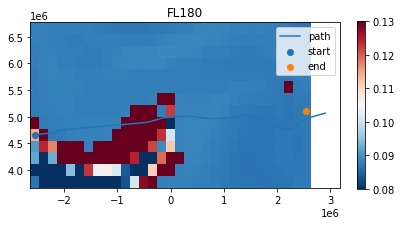

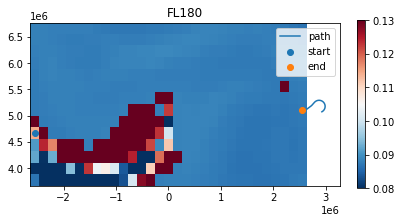

In [74]:
plot_path(history, flights.iloc[4])

In [71]:
for k in options.keys():
    plt.scatter(options[k]['coordinates'][0], options[k]['coordinates'][1], label=k)

plt.scatter(history[-1]['coordinates'][0], history[-1]['coordinates'][1], label='origin')
plt.scatter(history[-2]['coordinates'][0], history[-2]['coordinates'][1], label='origin-1')
plt.scatter(history[-3]['coordinates'][0], history[-3]['coordinates'][1], label='origin-2')

[x_r, y_r] = rotate(
    [history[-2]['coordinates'][0], history[-2]['coordinates'][1]],
    [history[-1]['coordinates'][0], history[-1]['coordinates'][1]],
    np.pi / 2
)
#plt.scatter(x_r, y_r, label='r')
#plt.xlim([6214000, 6230000])
#plt.ylim([-2550000, -2530000])

plt.axis('scaled')
plt.legend()
history_options[-1]

NameError: name 'options' is not defined

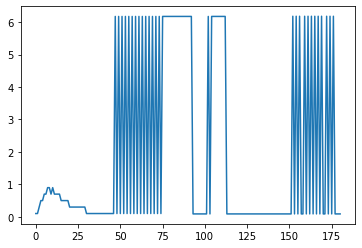

In [92]:
a = np.array([x['alpha'] for x in history])
plt.plot(a)

In [73]:
c = np.array([x['total_cost'] for x in history])
plt.plot(c)

KeyError: 'total_cost'

106.6

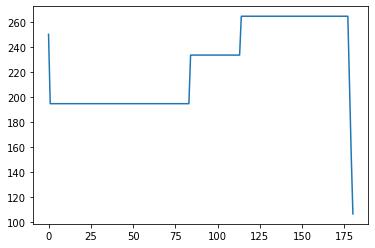

In [93]:
z_level = np.array([h['coordinates'][2] for h in history])
plt.plot(z_level)
min(z_level)

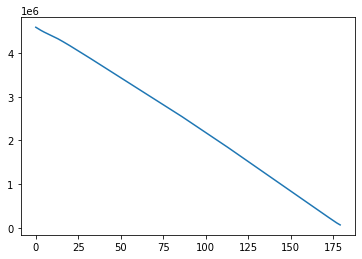

In [94]:
d = np.array([x['target_distance'] for x in history[1:]])
plt.plot(d)

In [95]:
flight

NameError: name 'flight' is not defined